In [1]:
import pandas as pd
import numpy as np

In [8]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import requests
import time

API_KEY = "b26f3e4b3e8d4cd2b2ea5dbc074e76fd"
BASE_URL = "https://api.weatherbit.io/v2.0/history/airquality"

# Kinh độ, vĩ độ Cần Thơ
LON = 106.647339
LAT = 10.839318    # lưu ý: lat 21.x là Hà Nội, Cần Thơ ~10.x

START_DATE = datetime(2023, 1, 1)
END_DATE = datetime(2025, 12, 1)

all_data = []
current = START_DATE

while current < END_DATE:
    # 👉 cộng 1 tháng
    block_end = current + relativedelta(months=1)

    if block_end > END_DATE:
        block_end = END_DATE

    params = {
        "lat": LAT,
        "lon": LON,
        "start_date": current.strftime("%Y-%m-%d"),
        "end_date": block_end.strftime("%Y-%m-%d"),
        "key": API_KEY
    }

    print(f"Fetching data from {params['start_date']} to {params['end_date']}")
    response = requests.get(BASE_URL, params=params)

    if response.status_code == 200:
        json_data = response.json()
        if json_data.get("data"):
            all_data.extend(json_data["data"])
            print(f"Fetched {len(json_data['data'])} records")
        else:
            print("No data found for this period")
    else:
        print(f"Failed: {response.status_code} - {response.text}")
        break

    # 👉 sang tháng tiếp theo (KHÔNG cộng thêm lần nữa)
    current = block_end
    time.sleep(7)

Fetching data from 2023-01-01 to 2023-02-01
Failed: 429 - 


In [ ]:
import pandas as pd

df = pd.DataFrame(all_data)
df.to_csv("cantho_air_quality_HCM.csv", index=False)

In [1]:
import pandas as pd
import numpy as np

In [ ]:
pd_ct = pd.read_csv("data/cleaned_data_CT.csv")
pd_hcm = pd.read_csv("data/cleaned_data_HCM.csv")
pd_hn = pd.read_csv("data/cleaned_data_HN.csv")

# thêm location
pd_ct["location"] = "CanTho"
pd_hcm["location"] = "HoChiMinh"
pd_hn["location"] = "Hanoi"
# ghép tất cả lại
df_full = pd.concat([pd_ct, pd_hcm, pd_hn], ignore_index=True)
df_full[df_full["location"] == "HoChiMinh"].describe()

,aqi,co,no2,o3,pm10,pm25,so2,temp,rh,pres,wind_spd,wind_dir,clouds,precip,pod,dewpt,wind_sin,wind_cos
count,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000
mean,80.064048,931.134002,30.906389,59.723027,34.814730,21.751708,63.503501,28.719549,77.245397,1008.533438,3.019513,186.126888,54.726027,0.312395,0.541645,23.925067,-0.108136,-0.212717
std,52.179933,3220.859665,72.923932,33.135727,31.871095,25.230134,105.981707,2.952564,15.882550,2.507855,1.619025,88.576198,25.861894,0.809802,0.498272,2.470775,0.720963,0.650605
min,8.000000,33.300000,1.000000,0.000000,1.000000,0.000000,1.000000,19.000000,26.000000,999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.800000,-1.000000,-1.000000
25%,53.000000,75.300000,6.700000,34.300000,20.000000,10.000000,16.700000,26.000000,66.000000,1007.000000,1.600000,130.000000,25.000000,0.000000,0.000000,22.900000,-0.870000,-0.770000
50%,68.000000,102.100000,14.000000,55.700000,30.000000,18.000000,33.700000,28.000000,79.000000,1008.000000,2.600000,192.000000,50.000000,0.000000,1.000000,24.800000,-0.170000,-0.340000
75%,94.000000,144.100000,28.000000,80.000000,42.700000,27.860000,68.000000,31.000000,89.000000,1010.000000,4.090000,250.000000,87.000000,0.250000,1.000000,25.800000,0.640000,0.340000
max,500.000000,15376.000000,955.000000,652.000000,504.000000,350.330000,721.000000,39.000000,100.000000,1018.000000,12.400000,360.000000,100.000000,17.500000,1.000000,29.000000,1.000000,1.000000


In [6]:
# Thêm feature 
#hours,day,month,year,spd_wind_sin,spd_wind_cos,is_stagnant,ah,dtr,dpd,ratio_pm,o,rush_hour,season_sin,delta_pm25,ma_pm25_4,rain_sum_6,w_pm25,pm25_lag_1,pm25_lag_3,pm25_lag_6,pm25_lag_24
df_full["hour"] = pd.to_datetime(df_full["timestamp_local"]).dt.hour
df_full["day"] = pd.to_datetime(df_full["timestamp_local"]).dt.day
df_full["month"] = pd.to_datetime(df_full["timestamp_local"]).dt.month
df_full["year"] = pd.to_datetime(df_full["timestamp_local"]).dt.year

# Gió
df_full["spd_wind_sin"] = df_full["wind_spd"] * df_full["wind_sin"]
df_full["spd_wind_cos"] = df_full["wind_spd"] * df_full["wind_cos"]

# Thời tiết
df_full["is_stagnant"] = np.where((df_full["wind_spd"] < 1.5) & (df_full["dewpt"] == 0), 1, 0)
df_full["ah"] = 6.112 * np.exp((17.67 * df_full["dewpt"]) / (df_full["dewpt"] + 243.5)) * 2.1674 / (273.15 + df_full["temp"])
df_full["dtr"] = df_full["temp"] - df_full["dewpt"]
df_full["dpd"] = df_full["temp"] - df_full["rh"]
df_full["ratio_pm"] = df_full["pm25"] / df_full["pm10"]
df_full["o"] = df_full["o3"] +df_full["co"]
df_full["rush_hour"] = np.where(((df_full["hour"] >= 6) & (df_full["hour"] <= 9)) | ((df_full["hour"] >= 16) & (df_full["hour"] <= 19)), 1, 0)
df_full["season_sin"] = np.sin(2 * np.pi * df_full["month"] / 12)
df_full["delta_pm25"] = df_full.groupby("location")["pm25"].diff().fillna(0)
df_full["ma_pm25_4"] = df_full.groupby("location")["pm25"].transform(lambda x: x.rolling(window=4, min_periods=1).mean())
df_full["rain_sum_6"] = df_full.groupby("location")["precip"].transform(lambda x: x.rolling(window=6, min_periods=1).sum())
df_full["w_pm25"] = df_full["wind_spd"] * df_full["pm25"]
df_full["pm25_lag_1"] = df_full.groupby("location")["pm25"].shift(1).fillna(0)
df_full["pm25_lag_3"] = df_full.groupby("location")["pm25"].shift(3).fillna(0)
df_full["pm25_lag_6"] = df_full.groupby("location")["pm25"].shift(6).fillna(0)
df_full["pm25_lag_24"] = df_full.groupby("location")["pm25"].shift(24).fillna(0)
df_full
df_full.to_csv("data/feature_engineered_air_quality_data.csv", index=False)

In [31]:

import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import plotly.express as px
import inspect
import time
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
%matplotlib inline
df_all = pd.read_csv("data/feature_engineered_air_quality_data.csv")
df_all["timestamp_local"] = pd.to_datetime(df_all["timestamp_local"])
df_all.set_index("timestamp_local", inplace=True)
df_all

,aqi,co,no2,o3,pm10,pm25,so2,temp,rh,pres,...,rush_hour,season_sin,delta_pm25,ma_pm25_4,rain_sum_6,w_pm25,pm25_lag_1,pm25_lag_3,pm25_lag_6,pm25_lag_24
timestamp_local,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,152.0,432.8,57.3,22.3,83.3,56.67,37.7,22.0,83.0,1015.0,...,0,5.000000e-01,0.00,56.6700,0.25,56.6700,0.00,0.00,0.00,0.0
2023-01-01 01:00:00,150.0,402.1,54.0,20.0,79.0,54.00,32.0,22.0,83.0,1014.0,...,0,5.000000e-01,-2.67,55.3350,0.25,113.4000,56.67,0.00,0.00,0.0
2023-01-01 02:00:00,134.0,361.2,45.3,24.3,70.3,48.00,31.7,22.0,83.0,1013.0,...,0,5.000000e-01,-6.00,52.8900,0.25,100.8000,54.00,0.00,0.00,0.0
2023-01-01 03:00:00,118.0,320.4,36.7,28.7,61.7,42.00,31.3,22.0,83.0,1013.0,...,0,5.000000e-01,-6.00,50.1675,0.25,88.2000,48.00,56.67,0.00,0.0
2023-01-01 04:00:00,102.0,279.5,28.0,33.0,53.0,36.00,31.0,22.0,78.0,1013.0,...,0,5.000000e-01,-6.00,45.0000,0.25,75.6000,42.00,54.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30 20:00:00,237.0,368.2,38.0,41.0,151.3,121.00,133.0,18.1,85.0,1014.0,...,0,-5.000000e-01,-22.00,134.5000,0.00,193.6000,143.00,143.00,107.67,111.8
2025-11-30 21:00:00,217.0,486.6,23.0,40.0,164.9,105.67,98.0,17.9,89.0,1014.0,...,0,-5.000000e-01,-15.33,125.1675,0.00,134.2009,121.00,131.00,101.00,120.4
2025-11-30 22:00:00,192.0,605.0,8.0,39.0,158.0,87.00,63.0,17.9,91.0,1014.0,...,0,-5.000000e-01,-18.67,114.1675,0.00,109.6200,105.67,143.00,109.00,123.6


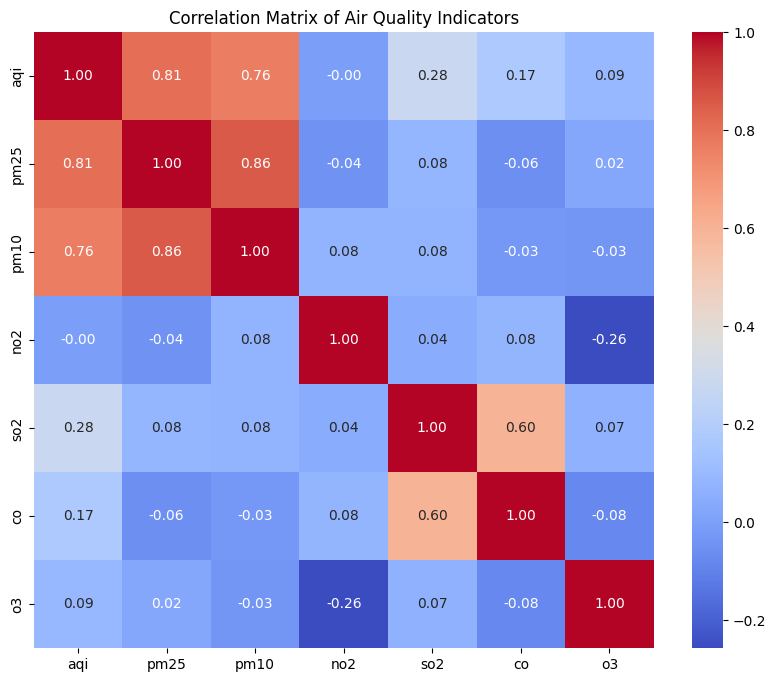

,aqi,co,no2,o3,pm10,pm25,so2,temp,rh,pres,...,rush_hour,season_sin,delta_pm25,ma_pm25_4,rain_sum_6,w_pm25,pm25_lag_1,pm25_lag_3,pm25_lag_6,pm25_lag_24
timestamp_local,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,152.0,432.8,57.3,22.3,83.3,56.67,37.7,22.0,83.0,1015.0,...,0,5.000000e-01,0.00,56.6700,0.25,56.6700,0.00,0.00,0.00,0.0
2023-01-01 01:00:00,150.0,402.1,54.0,20.0,79.0,54.00,32.0,22.0,83.0,1014.0,...,0,5.000000e-01,-2.67,55.3350,0.25,113.4000,56.67,0.00,0.00,0.0
2023-01-01 02:00:00,134.0,361.2,45.3,24.3,70.3,48.00,31.7,22.0,83.0,1013.0,...,0,5.000000e-01,-6.00,52.8900,0.25,100.8000,54.00,0.00,0.00,0.0
2023-01-01 03:00:00,118.0,320.4,36.7,28.7,61.7,42.00,31.3,22.0,83.0,1013.0,...,0,5.000000e-01,-6.00,50.1675,0.25,88.2000,48.00,56.67,0.00,0.0
2023-01-01 04:00:00,102.0,279.5,28.0,33.0,53.0,36.00,31.0,22.0,78.0,1013.0,...,0,5.000000e-01,-6.00,45.0000,0.25,75.6000,42.00,54.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30 20:00:00,237.0,368.2,38.0,41.0,151.3,121.00,133.0,18.1,85.0,1014.0,...,0,-5.000000e-01,-22.00,134.5000,0.00,193.6000,143.00,143.00,107.67,111.8
2025-11-30 21:00:00,217.0,486.6,23.0,40.0,164.9,105.67,98.0,17.9,89.0,1014.0,...,0,-5.000000e-01,-15.33,125.1675,0.00,134.2009,121.00,131.00,101.00,120.4
2025-11-30 22:00:00,192.0,605.0,8.0,39.0,158.0,87.00,63.0,17.9,91.0,1014.0,...,0,-5.000000e-01,-18.67,114.1675,0.00,109.6200,105.67,143.00,109.00,123.6


In [32]:
corr_columns = ["aqi","pm25","pm10","no2","so2","co","o3"]

corr_matrix = df_all[corr_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Air Quality Indicators")
plt.show()
df_all

In [34]:
df_pm25_hourly_hcm = df_all[df_all["location"] == "HoChiMinh"]["pm25"].copy()
df_pm25_hourly_hcm

timestamp_local
2023-01-01 00:00:00    69.33
2023-01-01 01:00:00    59.00
2023-01-01 02:00:00    55.00
2023-01-01 03:00:00    51.00
2023-01-01 04:00:00    47.00
                       ...  
2025-11-30 20:00:00    48.00
2025-11-30 21:00:00    30.50
2025-11-30 22:00:00    15.00
2025-11-30 23:00:00    29.00
2025-12-01 00:00:00    28.00
Name: pm25, Length: 25561, dtype: float64

In [37]:
df_pm25_daily = df_pm25_hourly_hcm.resample('D').agg('mean')
df_pm25 = df_pm25_daily
df_pm25.describe()

count    1066.000000
mean       21.757325
std        18.500980
min         0.562500
25%        12.448021
50%        19.034583
75%        26.833333
max       269.527917
Name: pm25, dtype: float64

In [55]:
df_all["pm25"].describe()
df_all["pm25"].max()

# df_pm25_hourly = df_all[["city","pm25"]].copy()
# df_pm25_hourly[df_pm25_hourly["pm25"] >= 500]
# df_pm25_hourly = df_pm25_hourly[df_pm25_hourly["city"]=="HoChiMinh"].copy().drop(columns=["city"])
# df_pm25_hourly[df_pm25_hourly["pm25"] >= 100]

np.float64(985.0)

In [ ]:
df_pm25.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1066 entries, 2023-01-01 to 2025-12-01
Freq: D
Series name: pm25
Non-Null Count  Dtype  
--------------  -----  
1066 non-null   float64
dtypes: float64(1)
memory usage: 16.7 KB


count    1066.000000
mean       30.257947
std        64.694646
min         0.562500
25%        12.448021
50%        19.423750
75%        29.336875
max       906.791667
Name: pm25, dtype: float64

In [24]:
df_pm25.describe()

count    1066.000000
mean       30.257947
std        64.694646
min         0.562500
25%        12.448021
50%        19.423750
75%        29.336875
max       906.791667
Name: pm25, dtype: float64

In [20]:
adf_result = adfuller(df_pm25)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

ADF Statistic: -3.8569791881868647
p-value: 0.0023752863600122677
Critical Values: {'1%': np.float64(-3.43662916802936), '5%': np.float64(-2.864312406409634), '10%': np.float64(-2.5682461404339336)}


<Axes: title={'center': 'HoChiMinh PM2.5 Levels, Daily Data'}, xlabel='Date', ylabel='PM2.5 Level'>

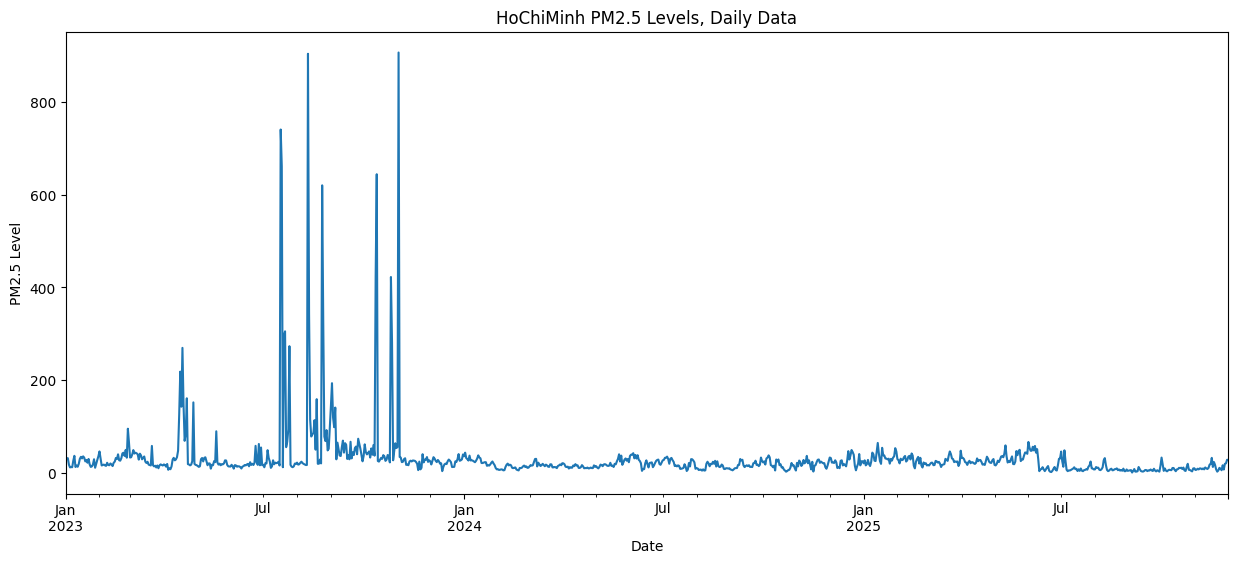

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
df_pm25.plot(xlabel = "Date",ylabel= "PM2.5 Level",
                           title= "HoChiMinh PM2.5 Levels, Daily Data", ax=ax)